## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
#tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
#import tensorflow.compat.v1 as tf
print(tf.__version__)

def dynam_GPU_ram():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

dynam_GPU_ram()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

ModuleNotFoundError: No module named 'google.colab'

In [3]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [4]:
# 直接下載 VOC2007 的資料集作為範例
if not os.path.exists("VOCdevkit"):
  os.system("wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar") # 下載 VOC 資料集
  os.system("tar xvf VOCtrainval_06-Nov-2007.tar") # 解壓縮資料集，會花幾分鐘
else:
  print("data exists")

data exists


以下的程式碼負責把下載下來的 Pascal VOC 資料集轉換為訓練模型時需要的格式，直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，調整了一部分程式碼，讓我們只 sample 前 100 張圖片來做示範，在 colab 中會花一些時間跑完

In [5]:
if not os.path.exists("2007_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  from os import getcwd

  sets=[('2007', 'train'), ('2007', 'val')]

  # Pascal VOC 的資料類別
  classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

  # 把 annotation 轉換訓練時需要的資料形態
  def convert_annotation(year, image_id, list_file):
      in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
      tree=ET.parse(in_file)
      root = tree.getroot()

      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

  wd = "."

  for year, image_set in sets:
      image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
      annotation_path = '%s_%s.txt'%(year, image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      for image_id in image_ids[:100]: # 只處理 100 張圖片來做範例
          list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
          convert_annotation(year, image_id, list_file)
          list_file.write('\n')
      list_file.close()

In [9]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [7]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [8]:
annotation_path = '2007_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=30,
        initial_epoch=30,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

W0131 15:39:37.873123 140571708462912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0131 15:39:37.873773 140571708462912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0131 15:39:37.875468 140571708462912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0131 15:39:37.875891 140571708462912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W013

Create YOLOv3 model with 9 anchors and 20 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 75) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 75) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.


W0131 15:39:45.899869 140571708462912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Train on 90 samples, val on 10 samples, with batch size 16.


W0131 15:39:47.090001 140571708462912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0131 15:39:47.090630 140571708462912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 7360.2854 - val_loss: 5082.8071
Epoch 2/50
5/5 [==============================] - 2s 308ms/step - loss: 3970.8657 - val_loss: 2734.1377
Epoch 3/50
5/5 [==============================] - 4s 718ms/step - loss: 2179.0657 - val_loss: 1539.8752
Epoch 4/50
5/5 [==============================] - 1s 272ms/step - loss: 1290.0083 - val_loss: 1001.7333
Epoch 5/50
5/5 [==============================] - 1s 272ms/step - loss: 829.5486 - val_loss: 624.8431
Epoch 6/50
5/5 [==============================] - 1s 276ms/step - loss: 584.5768 - val_loss: 461.0146
Epoch 7/50
5/5 [==============================] - 3s 514ms/step - loss: 431.0369 - val_loss: 407.9588
Epoch 8/50
5/5 [==============================] - 3s 670ms/step - loss: 348.6947 - val_loss: 310.1710
Epoch 9/50
5/5 [==============================] - 4s 734ms/step - loss: 297.6161 - val_loss: 280.2236
Epoch 10/50
5/5 [==============================] - 3s 665ms/step - loss: 260.

In [10]:
annotation_path = '2007_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

model.load_weights('./logs/000/trained_weights_stage_1.h5')

if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 4 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=60,
        initial_epoch=0,
        callbacks=[logging, checkpoint, reduce_lr])
    model.save_weights(log_dir + 'trained_weights_final.h5')

W0131 15:58:59.621613 140184923400000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0131 15:58:59.622648 140184923400000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0131 15:58:59.626006 140184923400000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0131 15:58:59.626781 140184923400000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W013

Create YOLOv3 model with 9 anchors and 20 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 75) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 75) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.


W0131 15:59:08.472019 140184923400000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Unfreeze all of the layers.
Train on 90 samples, val on 10 samples, with batch size 4.


W0131 15:59:17.537453 140184923400000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0131 15:59:17.538171 140184923400000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/60
22/22 [==============================] - 14s 636ms/step - loss: 38.8140 - val_loss: 47.8188
Epoch 2/60
22/22 [==============================] - 6s 259ms/step - loss: 31.6130 - val_loss: 45.2848
Epoch 3/60
22/22 [==============================] - 6s 260ms/step - loss: 30.0059 - val_loss: 42.9537
Epoch 4/60
22/22 [==============================] - 6s 260ms/step - loss: 28.1500 - val_loss: 20.8362
Epoch 5/60
22/22 [==============================] - 6s 261ms/step - loss: 26.5317 - val_loss: 37.9102
Epoch 6/60
22/22 [==============================] - 6s 261ms/step - loss: 26.4399 - val_loss: 36.6436
Epoch 7/60
22/22 [==============================] - 6s 261ms/step - loss: 25.5209 - val_loss: 37.3056

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
Epoch 8/60
22/22 [==============================] - 6s 262ms/step - loss: 25.8147 - val_loss: 21.3227
Epoch 9/60
22/22 [==============================] - 6s 262ms/step - loss: 23.4955 - val_loss: 34.2812

In [11]:
from PIL import Image
image = Image.open('dog.jpg') 

In [12]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 3 boxes for img
dog 0.41 (149, 127) (298, 576)
car 0.50 (402, 91) (759, 156)
bicycle 0.59 (183, 192) (570, 381)
1.7097949829912977


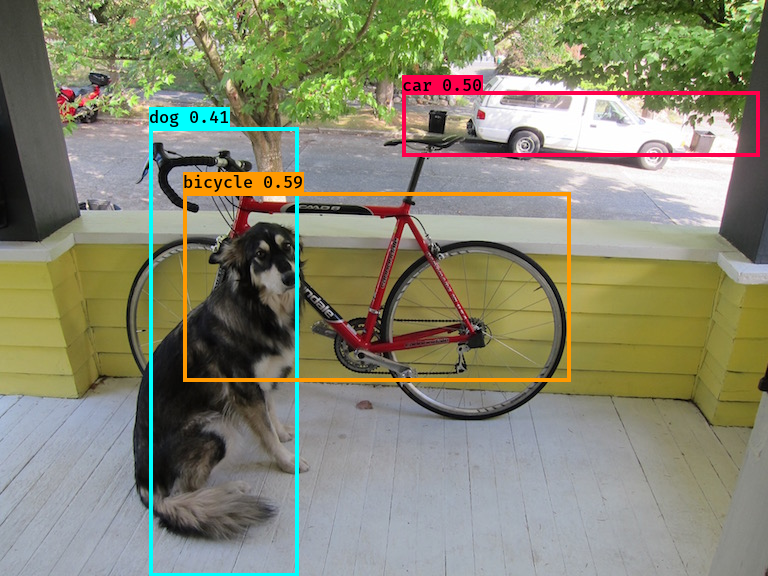

In [13]:
r_image

In [14]:
with open("2007_train.txt", "r") as f:
  d = f.readlines()
d

['./VOCdevkit/VOC2007/JPEGImages/000012.jpg 156,97,351,270,6\n',
 './VOCdevkit/VOC2007/JPEGImages/000017.jpg 185,62,279,199,14 90,78,403,336,12\n',
 './VOCdevkit/VOC2007/JPEGImages/000023.jpg 9,230,245,500,1 230,220,334,500,1 2,1,117,369,14 3,2,243,462,14 225,1,334,486,14\n',
 './VOCdevkit/VOC2007/JPEGImages/000026.jpg 90,125,337,212,6\n',
 './VOCdevkit/VOC2007/JPEGImages/000032.jpg 104,78,375,183,0 133,88,197,123,0 195,180,213,229,14 26,189,44,238,14\n',
 './VOCdevkit/VOC2007/JPEGImages/000033.jpg 9,107,499,263,0 421,200,482,226,0 325,188,411,223,0\n',
 './VOCdevkit/VOC2007/JPEGImages/000034.jpg 116,167,360,400,18 141,153,333,229,18\n',
 './VOCdevkit/VOC2007/JPEGImages/000035.jpg 1,96,191,361,14 218,98,465,318,14\n',
 './VOCdevkit/VOC2007/JPEGImages/000036.jpg 27,79,319,344,11\n',
 './VOCdevkit/VOC2007/JPEGImages/000042.jpg 263,32,500,295,18 1,36,235,299,18\n',
 './VOCdevkit/VOC2007/JPEGImages/000044.jpg 1,1,370,330,8 99,101,312,213,7\n',
 './VOCdevkit/VOC2007/JPEGImages/000047.jpg 15